In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import imp
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

RANDOM_SEED = 0
numpy2ri.activate()
ro.r('set.seed({})'.format(RANDOM_SEED))

import fairtest.utils.log as fairtest_log
imp.reload(fairtest_log)
fairtest_log.set_params(filename='fairtest.log')

In [5]:
import fairtest.utils.prepare_data as prepare
import fairtest.investigation as inv
import fairtest.testing as testing
import fairtest.discovery as discovery
import fairtest.error_profiling as error_profiling
import fairtest.modules.metrics as metrics
import fairtest.modules.metrics.correlation as correlation
import fairtest.modules.metrics.regression as regression
import fairtest.modules.metrics.binary_metrics as binary_metrics
import fairtest.modules.statistics.confidence_interval as intervals
import ast
import sklearn.preprocessing as preprocessing
imp.reload(intervals)
imp.reload(inv)
imp.reload(testing)
imp.reload(discovery)
imp.reload(error_profiling)
imp.reload(metrics)
imp.reload(correlation)
imp.reload(binary_metrics)
imp.reload(regression)


dataname = 'movies.txt'


# Testing Investigation on Movie Ratings
data1 = prepare.data_from_csv(
            '../data/recommender/recommendations.txt',
            sep='\\t',
            to_drop=['RMSE', 'Types', 'Avg Movie Age'])
SENS = ['Gender', 'Age']
TARGET = 'Avg Movie Rating'
EXPL = []

data1['Age'] = map(lambda a: 10 if a == 1 
                      else 20 if a == 18 
                      else 30 if a == 25 
                      else 40 if a == 35 
                      else 50 if a == 45 or a == 50
                      else 60 if a == 56 else None, data1['Age'])
test_ratings = testing.Testing(data1, SENS, TARGET, EXPL, train_size=0.5, random_state=RANDOM_SEED)


# Testing Investigation on RMSE
data3 = prepare.data_from_csv(
            '../data/recommender/recommendations.txt',
            sep='\\t',
            to_drop=['Types', 'Avg Movie Age', 'Avg Movie Rating'])
SENS = ['Gender', 'Age']
TARGET = 'RMSE'
EXPL = []

data3['Age'] = map(lambda a: 10 if a == 1 
                      else 20 if a == 18 
                      else 30 if a == 25 
                      else 40 if a == 35 
                      else 50 if a == 45 or a == 50
                      else 60 if a == 56 else None, data3['Age'])
test_rmse = testing.Testing(data3, SENS, TARGET, EXPL, train_size=0.5, random_state=RANDOM_SEED)


# Discovery Investigation on Movie Types
data2 = prepare.data_from_csv(
            '../data/recommender/recommendations.txt',
            sep='\\t',
            to_drop=['Occupation', 'Avg Movie Age', 'Avg Movie Rating', 'RMSE'])
TARGET = 'Types'
SENS = ['Gender', 'Age']
EXPL = []

data2['Age'] = map(lambda a: '<35' if a < 35 else '>=35', data2['Age'])

labeled_data = map(lambda s: ast.literal_eval(s), data2[TARGET])
for labels in labeled_data:
    assert(len(labels) == 5)
label_encoder = preprocessing.MultiLabelBinarizer()
labeled_data = label_encoder.fit_transform(labeled_data)
labels = label_encoder.classes_
df_labels = pd.DataFrame(labeled_data, columns=labels)
data2 = pd.concat([data2.drop(TARGET, axis=1), df_labels], axis=1)
TARGET = labels.tolist()

discovery_types = discovery.Discovery(data2, SENS, TARGET, EXPL, train_size=0.5, topk=15, random_state=RANDOM_SEED)
                                      

# Testing Investigation on Movie Age                                      
data4 = prepare.data_from_csv(
            '../data/recommender/recommendations.txt',
            sep='\\t',
            to_drop=['Types', 'Avg Movie Rating', 'RMSE'])
TARGET = 'Avg Movie Age'
SENS = ['Gender', 'Age']
EXPL = []

data4['Age'] = map(lambda a: 10 if a == 1 
                      else 20 if a == 18 
                      else 30 if a == 25 
                      else 40 if a == 35 
                      else 50 if a == 45 or a == 50
                      else 60 if a == 56 else None, data4['Age'])                              

test_ages = testing.Testing(data4, SENS, TARGET, EXPL, train_size=0.5, random_state=RANDOM_SEED)

investigations = [test_ratings, test_rmse, test_ages, discovery_types]

INFO:root:New Testing Investigation
INFO:root:Encoding Feature Gender
INFO:root:Encoding Feature Occupation
INFO:root:Target Feature: Target(names=['Avg Movie Rating'], arity=None)
INFO:root:Training Size 3020 -  Testing Size 3020
INFO:root:Choosing metric CORR for feature Gender
INFO:root:Choosing metric CORR for feature Age
INFO:root:New Testing Investigation
INFO:root:Encoding Feature Gender
INFO:root:Encoding Feature Occupation
INFO:root:Target Feature: Target(names=['RMSE'], arity=None)
INFO:root:Training Size 3020 -  Testing Size 3020
INFO:root:Choosing metric CORR for feature Gender
INFO:root:Choosing metric CORR for feature Age
INFO:root:New Discovery Investigation
INFO:root:Encoding Feature Gender
INFO:root:Encoding Feature Age
INFO:root:Target Feature: Target(names=[Action ... Western], arity=None)
INFO:root:Training Size 3020 -  Testing Size 3020
INFO:root:Choosing metric REGRESSION for feature Gender
INFO:root:Choosing metric REGRESSION for feature Age
INFO:root:New Testing

In [6]:
import fairtest.modules.context_discovery.guided_tree as guided_tree
imp.reload(guided_tree)
inv.train(investigations, score_aggregation='avg', min_leaf_size=100, max_depth=0)

INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Gender
INFO:root:Building a Guided Decision Tree
INFO:root:Begin training phase with protected feature Age
INFO:root:Building a Guided Decision Tree


In [7]:
import fairtest.modules.statistics.hypothesis_test as tests
import fairtest.modules.statistics.multiple_testing as multitest
import fairtest.modules.context_discovery.tree_parser as tree_parser
import fairtest.modules.statistics.confidence_interval as intervals
imp.reload(tests)
imp.reload(multitest)
imp.reload(tree_parser)
imp.reload(intervals)

inv.test(investigations, exact=True, prune_insignificant=True)

INFO:root:Begin testing phase
INFO:root:Testing 36 hypotheses


Commit Hash: 	06a56774982efbb58bc65a8a17b119cfe37325b7

Dataset: movies.txt
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: ['Occupation']
E: None
O: ['Avg Movie Rating']

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 0, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'level': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations on Si = Gender:
Association metric: CORR

Global Population of size 3020



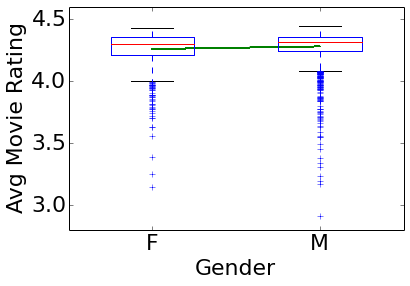

p-value = 3.05e-03 ; CORR = [0.0112, 0.1269]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.0112, 0.1269] ; Size = 3020
--------------------------------------------------------------------------------

Report of associations on Si = Age:
Association metric: CORR

Global Population of size 3020



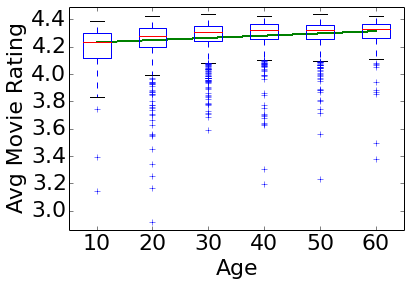

p-value = 6.70e-15 ; CORR = [0.0913, 0.2050]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.0913, 0.2050] ; Size = 3020
--------------------------------------------------------------------------------

Commit Hash: 	06a56774982efbb58bc65a8a17b119cfe37325b7

Dataset: movies.txt
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: ['Occupation']
E: None
O: ['RMSE']

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 0, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'level': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations on Si = Gender:
Association metric: CORR

Global Population of size 3020



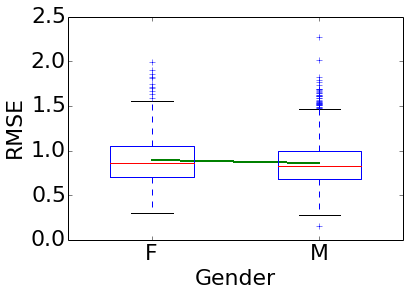

p-value = 1.51e-02 ; CORR = [-0.1190, -0.0031]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [-0.1190, -0.0031] ; Size = 3020
--------------------------------------------------------------------------------

Report of associations on Si = Age:
Association metric: CORR

Global Population of size 3020



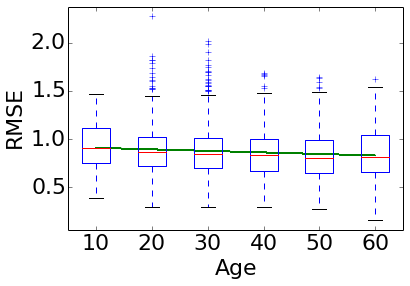

p-value = 4.94e-04 ; CORR = [-0.1349, -0.0193]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [-0.1349, -0.0193] ; Size = 3020
--------------------------------------------------------------------------------

Commit Hash: 	06a56774982efbb58bc65a8a17b119cfe37325b7

Dataset: movies.txt
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: ['Occupation']
E: None
O: ['Avg Movie Age']

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 0, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'level': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations on Si = Gender:
Association metric: CORR

Global Population of size 3020



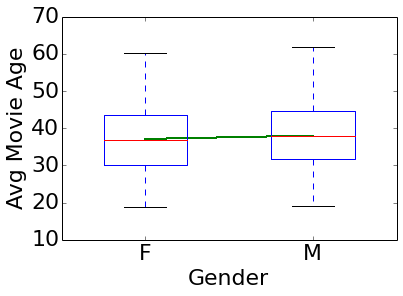

p-value = 1.23e-01 ; CORR = [-0.0101, 0.1059]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [-0.0101, 0.1059] ; Size = 3020
--------------------------------------------------------------------------------

Report of associations on Si = Age:
Association metric: CORR

Global Population of size 3020



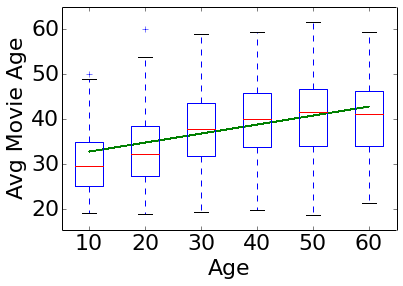

p-value = 3.08e-61 ; CORR = [0.2414, 0.3476]

Hierarchical printing of subpopulations (summary)


 Context = {} ; CI = [0.2414, 0.3476] ; Size = 3020
--------------------------------------------------------------------------------

Commit Hash: 	06a56774982efbb58bc65a8a17b119cfe37325b7

Dataset: movies.txt
Train Size: 3020
Test Size: 3020
S: ['Gender', 'Age']
X: []
E: None
O: [Action ... Western]

Train Params: 	{'max_bins': 10, 'min_leaf_size': 100, 'max_depth': 0, 'agg_type': 'avg'}
Test Params: 	{'prune_insignificant': True, 'exact': True, 'level': 0.95}
Report Params: 	{'node_filter': 'better_than_ancestors'}

Report of associations on Si = Gender:
Association metric: REG(topk=15)

Global Population of size 3020

Average Effect of top-15 labels: 0.029824614297

               ci_low   ci_high          pval
Romance      0.188333  0.311775  8.010277e-37
Action      -0.214566 -0.089864  1.970463e-13
Musical      0.030705  0.092729  6.162025e-09
Thriller    -0.180156 -0.051353  2.55657

In [8]:
import fairtest.modules.bug_report.report as rep
import fairtest.modules.bug_report.filter_rank as fr
imp.reload(rep)
imp.reload(inv)
imp.reload(fr)

inv.report(investigations, dataname, level=0.95, output_dir=None, node_filter=fr.FILTER_BETTER_THAN_ANCESTORS)